要模拟一个情景，其中有600个人站成一排，每次随机杀掉一个奇数位置的人，目的是找出哪个位置的人最安全。具体实现可以分为以下几个步骤和解释：

### 1. 问题理解

- **初始状态**：有600个人站成一排，编号从1到600。
- **杀人规则**：每一轮中，随机选择当前存活的奇数编号的人，杀掉他们。
- **最终目标**：运行多次模拟，统计每个人被杀的轮次，找出哪些编号的人最晚被杀，或者可能存活到最后。

### 2. 实现思路

实现的关键在于通过多次模拟，记录每个编号的人在每次模拟中被杀的轮次，然后通过统计找到最安全的位置。

### 3. 关键步骤解释

1. **`random_kill(n)` 和 `random_kill_list(alive_ids)` 函数**：
   - `random_kill(n)`：在给定范围内随机选择一个奇数位置的人。
   - `random_kill_list(alive_ids)`：从当前存活的人中，选择一个奇数位置的人进行淘汰。

2. **`run_simulation_numpy(num_people)` 函数**：
   - `ids`：表示所有人的编号，从1到600。
   - `status`：表示每个人的生存状态，1表示存活，0表示被淘汰。
   - `killed_turn`：记录每个人被淘汰的回合，初始值为-1表示尚未被淘汰。
   - 每轮循环中，`alive_ids`会筛选出当前存活的编号，然后随机淘汰其中一个奇数编号的人。
   - 淘汰后更新 `status` 和 `killed_turn`，最后将结果存储在一个DataFrame中。

3. **多次模拟**：
   - 通过循环运行 `run_simulation_numpy(num_people)` N次（例如20000次），在每次模拟中记录每个人的淘汰回合。
   - 结果存储在 `df_simul` DataFrame中，每一列表示一次模拟的结果。



In [1]:
import pandas as pd
import numpy as np
import random
import warnings
import seaborn as sns
from pylab import mpl, plt

# best font and style settings for notebook
warnings.filterwarnings('ignore')
sns.set_style("white")
mpl.rcParams['font.family'] = '微软雅黑'
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook


def random_kill(n):
    # 生成一个随机的奇数，范围从0到n-1
    return random.choice([i for i in range(n) if i % 2 == 0])


def random_kill_list(alive_ids):
    n = len(alive_ids)
    return alive_ids[random_kill(n)]


def run_simulation_numpy(num_people):

    # 初始化 NumPy 数组
    ids = np.arange(1, num_people + 1)
    status = np.ones(num_people, dtype=int)  # 1表示存活
    killed_turn = np.full(num_people, -1)  # 初始化淘汰回合

    for turn in range(num_people):
        alive_ids = ids[status == 1]  # 获取当前存活的ID
        if len(alive_ids) == 0:  # 如果没有存活者，提前退出循环
            break

        kill_id = random_kill_list(alive_ids) - 1  # 选择要淘汰的ID

        status[kill_id] = 0  # 标记为淘汰
        killed_turn[kill_id] = turn + 1  # 记录淘汰回合

    # 转换为 DataFrame
    df = pd.DataFrame({
        "id": ids,
        "status": status,
        "killed_turn": killed_turn
    })

    return df


#
num_people = 600
N = 30000
df_simul = pd.DataFrame({"id": range(1, 1 + num_people)})
for i in tqdm_notebook(range(N)):
    result_df = run_simulation_numpy(num_people)
    df_simul[f'turn_{i}'] = result_df['killed_turn']

result_df

  0%|          | 0/30000 [00:00<?, ?it/s]

,id,status,killed_turn
0,1,0,148
1,2,0,188
2,3,0,15
3,4,0,301
4,5,0,152
...,...,...,...
595,596,0,36
596,597,0,470
597,598,0,149
598,599,0,139


In [2]:
df_simul.iloc[df_simul.iloc[:,1:].idxmax()]

,id,turn_0,turn_1,turn_2,turn_3,turn_4,turn_5,turn_6,turn_7,turn_8,...,turn_29990,turn_29991,turn_29992,turn_29993,turn_29994,turn_29995,turn_29996,turn_29997,turn_29998,turn_29999
588,589,600,404,9,565,384,519,477,485,423,...,53,94,136,561,136,87,1,577,350,590
574,575,210,600,441,392,277,283,57,447,482,...,586,501,556,149,379,179,152,535,92,386
511,512,306,544,600,571,407,573,65,198,436,...,548,542,450,72,8,91,482,82,555,412
184,185,317,229,576,600,103,504,105,385,375,...,413,344,236,497,386,196,372,560,86,151
320,321,355,376,231,490,600,335,578,512,146,...,202,472,139,381,54,241,575,55,228,538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,351,130,297,190,251,510,542,100,577,247,...,34,551,162,590,300,600,503,244,280,436
383,384,271,537,157,542,582,149,55,487,566,...,559,144,509,303,185,515,600,264,75,197
397,398,121,124,114,480,371,193,303,505,208,...,541,125,287,588,346,526,543,600,542,372
593,594,544,409,491,310,576,550,323,87,120,...,55,494,178,137,98,512,319,321,600,437


<AxesSubplot:xlabel='id'>

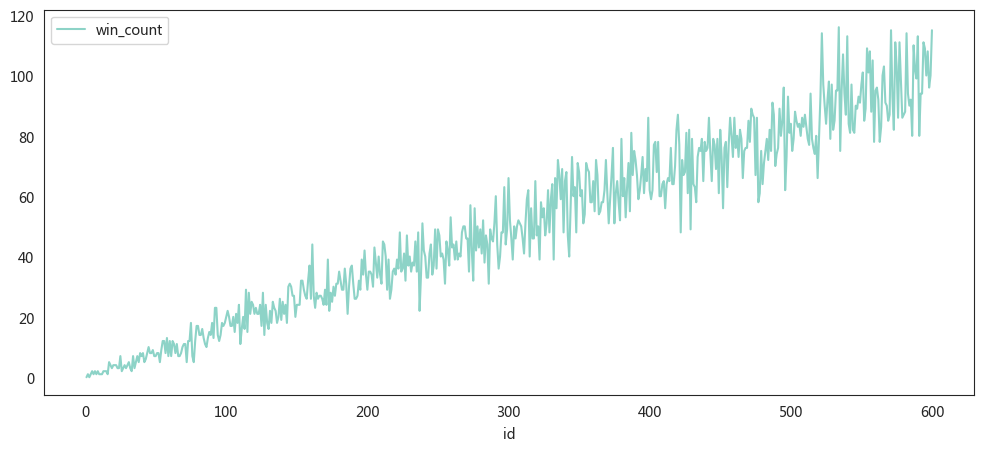

In [3]:
# 统计每个ID成为最后一个被淘汰的次数
last_killed = df_simul.iloc[:, 1:].idxmax()
last_killed_counts = {}
for i in range(1, len(df_simul )+1):
    last_killed_counts[i] = 0
# print(last_killed_counts.keys())
for i in df_simul.loc[df_simul.iloc[:, 1:].idxmax()]['id']:
    last_killed_counts[i] += 1
last_killed_counts = pd.DataFrame({
    'id': last_killed_counts.keys(),
    'win_count': last_killed_counts.values()
})

last_killed_counts.plot(x='id',y='win_count',figsize=(12,5))

In [4]:
last_killed_counts.sort_values('win_count',ascending=False)

,id,win_count
533,534,116
599,600,115
570,571,115
521,522,114
581,582,114
...,...,...
10,11,1
15,16,1
1,2,1
2,3,0


In [5]:
df_simul['average_alive_turns'] = df_simul.T.mean()
df_simul[['id', 'average_alive_turns']].sort_values(by='average_alive_turns',
                                                    ascending=False)

,id,average_alive_turns
1,2,333.359621
3,4,323.824506
5,6,318.130562
7,8,313.649845
9,10,312.418386
...,...,...
8,9,284.330722
6,7,279.718343
4,5,272.159295
2,3,255.096263


<AxesSubplot:xlabel='id'>

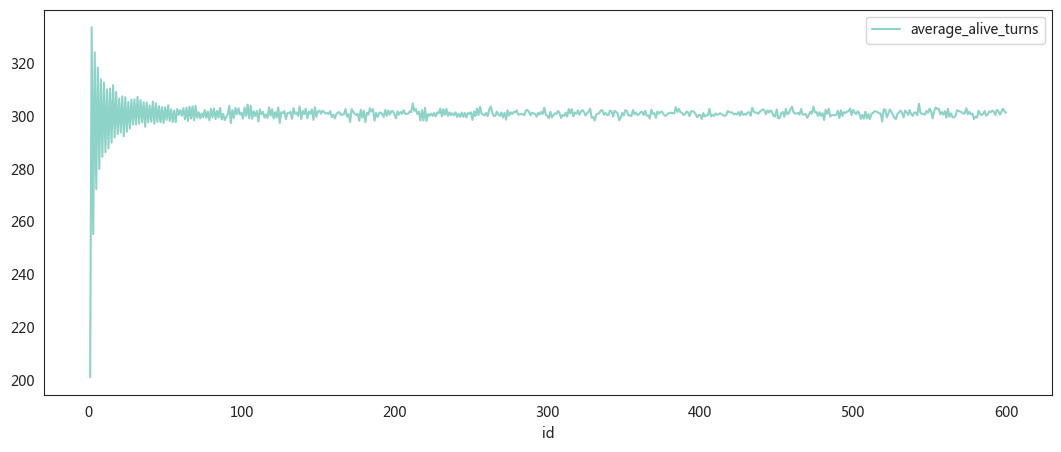

In [6]:
df_simul[['id', 'average_alive_turns']].plot(x='id',y='average_alive_turns',figsize=(13,5))

In [7]:
!jupyter nbconvert --to html random_kill_final.ipynb

[NbConvertApp] Converting notebook random_kill_final.ipynb to html
[NbConvertApp] Writing 423366 bytes to random_kill_final.html
